In [1]:
from CONFIG import *

In [2]:
import torch

In [3]:
import os

In [4]:
import torch.nn as nn

In [5]:
from torch.utils import model_zoo

In [6]:
from Our_VGG16 import vgg

In [7]:
from yoloLoss import yoloLoss

In [8]:
from torch.nn.init import xavier_uniform

In [9]:
import time

In [10]:
net = vgg(False)

In [11]:
net.batch_norm

False

In [12]:
if net.batch_norm:
    net.load_state_dict(model_zoo.load_url(vgg16_batch_norm_url))
else:
    net.load_state_dict(model_zoo.load_url(vgg16_url))


In [13]:
net.classifier = nn.Sequential(
                    nn.Linear(512*7*7,4096),
                    nn.ReLU(True),
                    nn.Dropout(),
                    nn.Linear(4096,1470))

In [14]:
for layer in net.classifier:
    print(layer)
    print("--------------------")
    if isinstance(layer,nn.Linear):
        xavier_uniform(layer.weight.data)

Linear(in_features=25088, out_features=4096, bias=True)
--------------------
ReLU(inplace)
--------------------
Dropout(p=0.5)
--------------------
Linear(in_features=4096, out_features=1470, bias=True)
--------------------


In [15]:
if torch.cuda.is_available():
    net.cuda()

In [16]:
net.train()

vgg(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    

In [17]:
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,weight_decay=weight_decay)

In [17]:
optimizer2 = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0.9, weight_decay=5e-4)

In [18]:
train_imgs_dir = 'VOC_Datasets/VOC_2012_training/VOC2012/JPEGImages/'
train_ann_dir = 'voc2012train.txt'
val_imgs_dir = 'VOC_Datasets/VOC_2007_testing/VOCdevkit/VOC2007/JPEGImages/'
val_ann_dir = 'voc2007test.txt'

In [19]:
from dataset import yoloDataset
import torchvision.transforms as transforms

In [20]:
img_names = os.listdir(train_imgs_dir)
train_dataset = yoloDataset(train_imgs_dir,train_ann_dir,train = True, transform = [transforms.ToTensor()])
val_dataset = yoloDataset(val_imgs_dir,val_ann_dir,train = False, transform = [transforms.ToTensor()])

data init
data init


In [21]:
from torch.utils.data import DataLoader

In [22]:
train_batches = DataLoader(train_dataset,batch_size = batch_size, shuffle = False, num_workers = 2)
val_batches = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 2)

In [23]:
len(train_dataset)

17125

In [24]:
len(val_dataset)

4952

In [25]:
print len(train_batches), len(val_batches)

536 155


In [26]:
from torch.autograd import Variable

In [27]:
yoloLossCriterion = yoloLoss(7,2,5,0.5)

In [28]:
train_loss_list = []
val_loss_list = []

In [29]:
def batch_process(mode,j):
    loss_list = []
    time_list = []
    total_time = 0
    if mode == 'train':
        print("Training")
        net.train()
        batches = train_batches
    else:
        net.eval()
        batches = val_batches
    for (images,targets) in batches:
        start = time.time()
        images,targets = Variable(images),Variable(targets)
        if torch.cuda.is_available():
            images = images.cuda()
            targets = targets.cuda()
        predictions = net(images)
        loss = yoloLossCriterion(predictions,targets)
    #         print(loss.data[0])
    
        loss_list.append(loss.data[0])
        if mode == 'train':
            if loss.data[0] < lowest_training_loss:
                torch.save(net.state_dict(),'training_weights.pth')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            if loss.data[0] < lowest_val_loss:
                torch.save(net.state_dict(),'validation_weights.pth')                
        j += 1
        end = time.time()
    #         if (j-1)%5 == 0:
        print "Epoch : ", i+1 , "/", num_epochs,"\n"
        print "Batch : ",j, "/",len(batches)," : Loss is :", loss.data[0]
        print "The time for this batch was :",(end - start)
        time_list.append(end - start)
        total_time += time_list[-1]
    return loss_list,time_list,total_time

In [30]:
# if 'validation_weights.pth' in os.listdir('./'):
#     net.load_state_dict(torch.load('validation_weights.pth'))
lowest_training_loss = float("inf")
lowest_val_loss = float("inf")

i = 0
training_loss_list = []
val_loss_list = []
while i < 1:
    j = 0
    training_loss_list,time_list,total_time = batch_process('train',j)
    
#     val_loss_list,time_list,total_time = batch_process('train',j)
    i += 1
        
    
            
        
        
    

Training
Epoch :  1 / 100 

Batch :  1 / 536  : Loss is : 32.9653930664
The time for this batch was : 3.34430122375
Epoch :  1 / 100 

Batch :  2 / 536  : Loss is : 15.6533679962
The time for this batch was : 1.71066188812
Epoch :  1 / 100 

Batch :  3 / 536  : Loss is : 12.5708351135
The time for this batch was : 1.5810008049
Epoch :  1 / 100 

Batch :  4 / 536  : Loss is : 14.0073337555
The time for this batch was : 1.63492202759
Epoch :  1 / 100 

Batch :  5 / 536  : Loss is : 13.1517486572
The time for this batch was : 1.71196603775
Epoch :  1 / 100 

Batch :  6 / 536  : Loss is : 11.6093854904
The time for this batch was : 1.63948583603
Epoch :  1 / 100 

Batch :  7 / 536  : Loss is : 16.9084358215
The time for this batch was : 1.77022910118
Epoch :  1 / 100 

Batch :  8 / 536  : Loss is : 18.2672805786
The time for this batch was : 1.70009303093
Epoch :  1 / 100 

Batch :  9 / 536  : Loss is : 11.4327049255
The time for this batch was : 1.62121987343
Epoch :  1 / 100 

Batch :  1

Epoch :  1 / 100 

Batch :  77 / 536  : Loss is : 9.0981054306
The time for this batch was : 1.9045817852
Epoch :  1 / 100 

Batch :  78 / 536  : Loss is : 6.27484893799
The time for this batch was : 1.60167312622
Epoch :  1 / 100 

Batch :  79 / 536  : Loss is : 6.84199428558
The time for this batch was : 1.64158892632
Epoch :  1 / 100 

Batch :  80 / 536  : Loss is : 7.335688591
The time for this batch was : 1.68473601341
Epoch :  1 / 100 

Batch :  81 / 536  : Loss is : 6.73822307587
The time for this batch was : 1.71547794342
Epoch :  1 / 100 

Batch :  82 / 536  : Loss is : 6.11183834076
The time for this batch was : 1.68240499496
Epoch :  1 / 100 

Batch :  83 / 536  : Loss is : 9.26369953156
The time for this batch was : 1.65063118935
Epoch :  1 / 100 

Batch :  84 / 536  : Loss is : 5.59788179398
The time for this batch was : 1.53968000412
Epoch :  1 / 100 

Batch :  85 / 536  : Loss is : 7.79233169556
The time for this batch was : 1.5969889164
Epoch :  1 / 100 

Batch :  86 / 

Epoch :  1 / 100 

Batch :  153 / 536  : Loss is : 5.35462427139
The time for this batch was : 1.68031811714
Epoch :  1 / 100 

Batch :  154 / 536  : Loss is : 6.73339509964
The time for this batch was : 1.59759497643
Epoch :  1 / 100 

Batch :  155 / 536  : Loss is : 7.29712915421
The time for this batch was : 1.59983587265
Epoch :  1 / 100 

Batch :  156 / 536  : Loss is : 7.84459781647
The time for this batch was : 1.59479594231
Epoch :  1 / 100 

Batch :  157 / 536  : Loss is : 6.35937690735
The time for this batch was : 1.62489390373
Epoch :  1 / 100 

Batch :  158 / 536  : Loss is : 6.74441194534
The time for this batch was : 1.62654900551
Epoch :  1 / 100 

Batch :  159 / 536  : Loss is : 5.4953994751
The time for this batch was : 1.63342499733
Epoch :  1 / 100 

Batch :  160 / 536  : Loss is : 7.57649517059
The time for this batch was : 1.62184715271
Epoch :  1 / 100 

Batch :  161 / 536  : Loss is : 8.62784767151
The time for this batch was : 1.65553689003
Epoch :  1 / 100 

B

The time for this batch was : 1.62376403809
Epoch :  1 / 100 

Batch :  229 / 536  : Loss is : 7.07834529877
The time for this batch was : 1.65973806381
Epoch :  1 / 100 

Batch :  230 / 536  : Loss is : 6.49592018127
The time for this batch was : 1.63798308372
Epoch :  1 / 100 

Batch :  231 / 536  : Loss is : 7.40350532532
The time for this batch was : 1.63938784599
Epoch :  1 / 100 

Batch :  232 / 536  : Loss is : 6.4291267395
The time for this batch was : 1.64255309105
Epoch :  1 / 100 

Batch :  233 / 536  : Loss is : 10.7607498169
The time for this batch was : 1.69531106949
Epoch :  1 / 100 

Batch :  234 / 536  : Loss is : 6.89020252228
The time for this batch was : 1.69007611275
Epoch :  1 / 100 

Batch :  235 / 536  : Loss is : 7.0666809082
The time for this batch was : 1.68951392174
Epoch :  1 / 100 

Batch :  236 / 536  : Loss is : 6.31265258789
The time for this batch was : 1.71297216415
Epoch :  1 / 100 

Batch :  237 / 536  : Loss is : 7.21167612076
The time for this bat

Epoch :  1 / 100 

Batch :  304 / 536  : Loss is : 7.51315975189
The time for this batch was : 1.7122399807
Epoch :  1 / 100 

Batch :  305 / 536  : Loss is : 7.44228315353
The time for this batch was : 1.6941549778
Epoch :  1 / 100 

Batch :  306 / 536  : Loss is : 9.35134029388
The time for this batch was : 1.66907405853
Epoch :  1 / 100 

Batch :  307 / 536  : Loss is : 6.87867736816
The time for this batch was : 1.64494800568
Epoch :  1 / 100 

Batch :  308 / 536  : Loss is : 5.55783319473
The time for this batch was : 1.64551091194
Epoch :  1 / 100 

Batch :  309 / 536  : Loss is : 8.62141227722
The time for this batch was : 1.73318910599
Epoch :  1 / 100 

Batch :  310 / 536  : Loss is : 6.67399454117
The time for this batch was : 1.68044614792
Epoch :  1 / 100 

Batch :  311 / 536  : Loss is : 7.00411462784
The time for this batch was : 1.72241187096
Epoch :  1 / 100 

Batch :  312 / 536  : Loss is : 6.37037754059
The time for this batch was : 1.6638250351
Epoch :  1 / 100 

Bat

Batch :  379 / 536  : Loss is : 9.68733596802
The time for this batch was : 1.63258814812
Epoch :  1 / 100 

Batch :  380 / 536  : Loss is : 7.03165912628
The time for this batch was : 1.61171293259
Epoch :  1 / 100 

Batch :  381 / 536  : Loss is : 5.58882808685
The time for this batch was : 1.66283488274
Epoch :  1 / 100 

Batch :  382 / 536  : Loss is : 9.08672618866
The time for this batch was : 1.5379178524
Epoch :  1 / 100 

Batch :  383 / 536  : Loss is : 8.38419055939
The time for this batch was : 1.75349593163
Epoch :  1 / 100 

Batch :  384 / 536  : Loss is : 7.29914093018
The time for this batch was : 1.89320111275
Epoch :  1 / 100 

Batch :  385 / 536  : Loss is : 5.90087366104
The time for this batch was : 1.68516182899
Epoch :  1 / 100 

Batch :  386 / 536  : Loss is : 8.20488548279
The time for this batch was : 1.77838897705
Epoch :  1 / 100 

Batch :  387 / 536  : Loss is : 6.81851434708
The time for this batch was : 1.77833795547
Epoch :  1 / 100 

Batch :  388 / 536  

Epoch :  1 / 100 

Batch :  455 / 536  : Loss is : 7.23525571823
The time for this batch was : 1.72460603714
Epoch :  1 / 100 

Batch :  456 / 536  : Loss is : 7.0914850235
The time for this batch was : 1.90842103958
Epoch :  1 / 100 

Batch :  457 / 536  : Loss is : 7.2162771225
The time for this batch was : 1.64476799965
Epoch :  1 / 100 

Batch :  458 / 536  : Loss is : 5.91244506836
The time for this batch was : 1.77898216248
Epoch :  1 / 100 

Batch :  459 / 536  : Loss is : 8.22989654541
The time for this batch was : 1.73127508163
Epoch :  1 / 100 

Batch :  460 / 536  : Loss is : 9.6072511673
The time for this batch was : 1.85977697372
Epoch :  1 / 100 

Batch :  461 / 536  : Loss is : 7.61728382111
The time for this batch was : 2.51007890701
Epoch :  1 / 100 

Batch :  462 / 536  : Loss is : 6.23197174072
The time for this batch was : 2.32757997513
Epoch :  1 / 100 

Batch :  463 / 536  : Loss is : 8.29145431519
The time for this batch was : 2.50236916542
Epoch :  1 / 100 

Bat

Batch :  530 / 536  : Loss is : 9.70748519897
The time for this batch was : 1.67211103439
Epoch :  1 / 100 

Batch :  531 / 536  : Loss is : 5.99546003342
The time for this batch was : 1.79498314857
Epoch :  1 / 100 

Batch :  532 / 536  : Loss is : 9.40369415283
The time for this batch was : 1.77818608284
Epoch :  1 / 100 

Batch :  533 / 536  : Loss is : 6.85896587372
The time for this batch was : 1.72112798691
Epoch :  1 / 100 

Batch :  534 / 536  : Loss is : 6.10375499725
The time for this batch was : 1.68243598938
Epoch :  1 / 100 

Batch :  535 / 536  : Loss is : 5.49940109253
The time for this batch was : 1.64050388336
Epoch :  1 / 100 

Batch :  536 / 536  : Loss is : 4.5415802002
The time for this batch was : 1.56984615326


In [31]:
len(training_loss_list)

536

Text(0.5,1,'Training Loss')

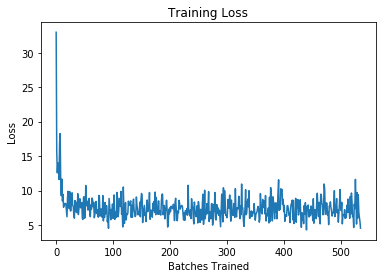

In [34]:
import matplotlib.pyplot as plt
plt.close()
plt.plot(range(len(training_loss_list)),training_loss_list)
plt.xlabel("Batches Trained")
plt.ylabel("Loss")
plt.title("Training Loss")

In [33]:
plt.show()

[]

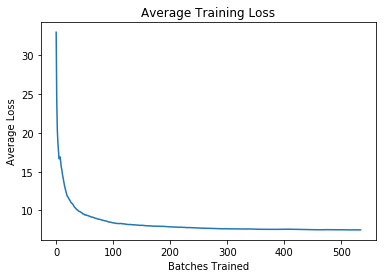

In [35]:
plt.close()
avg_list = []
l = training_loss_list
for i in range(1,len(l)):
    avg_list.append(sum(l[:i])/(1.0*len(l[:i])))
plt.plot(range(len(avg_list)),avg_list)
plt.xlabel("Batches Trained")
plt.ylabel("Average Loss")
plt.title("Average Training Loss")
plt.plot()

In [43]:
total_time

897.3796491622925

In [47]:
total_time/len(time_list)

1.674215763362486

In [39]:
total_time2

896.3470485210419

In [48]:
(total_time2+total_time22)/len(training_loss_list2+training_loss_list22)

1.6580117191396542

In [ ]:
print("Epoch : ", i+1 , "/", num_epochs,"\n")